# compute_vmodes
Compute vertical modes based on mean stratification

Strategy: process sequentially over y-segment, droping land points (columns) for each segment. This reduces the memory usage and is well adapted for a single-node dask cluster, but doesn't work if one wants to process large segments using a larger cluster. The efficiency of this script could be improved by having a mean not to load land points in memory within the distributed loop, e.g. through a map_blocks or something like that

#### Timing and memory consumption:
* not droping land: up to 90 GB
* droping lands: depends on the segment, but typically max at 55 GB
* first 2 y-segments of size 200: 50 & 60 minutes (dropping lands), 50 & 76 minutes (not dropping lands)

This notebook is for processing eNATL60 data on occigen


In [1]:
from pathlib import Path
import os, time, datetime

import xarray as xr
from xgcm import Grid
from itidenatl.nemodez import Vmodes, load_vmodes

In [2]:
from dask.distributed import Client, LocalCluster, wait
scratch = os.getenv("SCRATCHDIR")
cluster = LocalCluster(n_workers=14, local_directory=scratch) #n_workers=24, threads_per_worker=1, memory_limit=8e6,silence_logs=50
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:35950 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 14 Cores: 56 Memory: 236.33 GiB


In [3]:
### define paths
scratch = Path(os.getenv("SCRATCHDIR"))
works = Path("/work/CT1/ige2071/SHARED")
grid_path = scratch #Path("/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-I/")
mean_path = scratch #Path("/work/CT1/ige2071/SHARED/mean")

avg_type = "30d" # "30d" or "global"
avg_date = "20090630" # will be ignored if avg_type is "global"
app = "_"+avg_date if avg_type == "30d" else ""
zgrid_fname = f"eNATL60_{avg_type}-mean_z-grid{app}.zarr" 
strat_fname = f"eNATL60_{avg_type}-mean_bvf{app}.zarr"

zgrid_file = scratch/zgrid_fname
strat_file = scratch/strat_fname
out_file = works/f"vmodes/eNATL60_{avg_type}-mean_vmodes{app}.zarr"

### processing parameters
nmodes = 10
out_chk = {"mode":1, "x_c":-1, "z_c": 30, "z_l":30}
wrk_chk = {"x_c":200}
nseg_y = 200 # y-segment size: choose it a multiple or a divider of chunk size
drop_land = True
restart = 11 #False # False or jy


In [6]:
dg = xr.open_zarr(zgrid_file).astype("float32")
ds = xr.open_zarr(strat_file).astype("float32")

coord_copy = ["e3t", "e3w", "hbot", "tmask", "depth_c"] # WARNING remove depth_c_3d
ds = ds.assign_coords({co:dg[co] for co in coord_copy}).chunk(wrk_chk).unify_chunks()
# remove chunks from encoding, for zarr storage
for var in ds.coords.values(): 
    var.encoding.pop("chunks", None)
chunks = {k:v[0] for k,v in ds.chunks.items()}
ds


/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: Increasing number of chunks by factor of 30
  """


<xarray.Dataset>
Dimensions:    (x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates: (12/13)
    depth_l    (z_l) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
    ...         ...
    depth_c    (z_c) float64 dask.array<chunksize=(10,), meta=np.ndarray>
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
    e3t        (z_c, y_c, x_c) float32 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    e3w        (z_l, y_c, x_c) float32 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    hbot       (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    tmask      (z_c, y_c, x_c) float32 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
Data variables:
    bvf        (z_l, y_c, x_c) float32 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
Attributes:
    date_processed:       2021-10-12T11:02
    from_files:           ['/scratch/cnt0024/ige2071/nlahaye/eNATL60_30d-mean...
    processing notebook:  comp_mean_grid.ipynb
    simulation:           eNATL60

In [5]:
%%time
### create vmods object and zarr archive (delayed mode) 
if not restart:
    vmods = Vmodes(ds, Grid(ds, periodic=False), nmodes=nmodes, free_surf=True, 
                   persist=False, chunks=out_chk)
    put_attrs = {"from_files":[str(zgrid_file), str(strat_file)],
                 "simulation": "eNATL60", "processing notebook":"compute_vmodes.ipynb",
                 "date_processed":datetime.datetime.today().isoformat(timespec="minutes"),
                 "process_params_wrk_chk": [(k,v) for k,v in wrk_chk.items()]
                }
    put_attrs.update({f"process_params_{k}":eval(k) for k in ["nseg_y", "drop_land"]})
    vmods.ds.attrs = put_attrs
    vmods.store(out_file, coords=False, mode="w", compute=False, consolidated=True)
    vmods.ds

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.9 µs


In [6]:
%%time
### Compute and store, looping over y-segments

Ny = ds.y_c.size
region = {"z_c": slice(0,None), "z_l":slice(0,None), "mode":slice(0,None)}

def get_subds(ds):
    """ wrapper to get rid of land points (columns).
    Warning: this works only if x_c increment is 1 """
    lnd_pts = (ds.tmaskutil==0).sum().values
    print("number of land points: {} ({:.1f}%)".format(lnd_pts, lnd_pts*100/ds.tmaskutil.size),
         end="; ")
    index = ds.tmaskutil.max("y_c")
    index = index.where(index, drop=True).x_c - index.x_c[0] #
    #index = slice((int(index[0])//wrk_chk["x_c"])*wrk_chk["x_c"], int(index[-1])+1)
    index = slice(int(index[0]), int(index[-1])+1)
    sds = ds.isel(x_c=index)
    lnd_pts = (sds.tmaskutil==0).sum().values
    print("after selection: {} ({:.1f}%)".format(lnd_pts, lnd_pts*100/sds.tmaskutil.size))
    return sds, index

### this is the loop
jy_0 = restart*nseg_y if restart else 0
for jy in range(jy_0, Ny, nseg_y):
    tmes = time.time()
    sliy = slice(jy, min(jy+nseg_y, Ny))
    if drop_land:
        sds, slix = get_subds(ds.isel(y_c=sliy))
    else:
        sds = ds.isel(y_c=sliy)
        slix = slice(0, None)
    grid = Grid(sds, periodic=False)
    region.update({"y_c":sliy, "x_c":slix})
    vmods = Vmodes(sds, grid, modes=nmodes, free_surf=True, persist=False, 
               chunks=out_chk)
    vmods.ds = vmods.ds.where(vmods.ds.tmaskutil)
    vmods.store(out_file, coords=False, mode="a", compute=True, region=region)
    print("segment {0} done, size {1}, {2:.1f} min".format(jy, sds.x_c.size, 
                                                          (time.time()-tmes)/60)
         )

number of land points: 662451 (39.6%); after selection: 254251 (20.1%)
Store vertical modes in /work/CT1/ige2071/SHARED/vmodes/eNATL60_30d-mean_vmodes_20090630.zarr
segment 2200 done, size 6313, 115.9 min
number of land points: 708903 (42.4%); after selection: 388103 (28.7%)


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [4]:
ds_re = xr.open_zarr(out_file)
ds_re

<xarray.Dataset>
Dimensions:  (mode: 11, x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c      (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l      (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 295.5 296.5 297.5 298.5 299.5
Data variables:
    c        (y_c, x_c, mode) float32 dask.array<chunksize=(200, 8354, 1), meta=np.ndarray>
    norm     (y_c, x_c) float32 dask.array<chunksize=(200, 8354), meta=np.ndarray>
    phi      (y_c, x_c, z_c, mode) float32 dask.array<chunksize=(200, 8354, 30, 1), meta=np.ndarray>
    phiw     (y_c, x_c, z_l, mode) float32 dask.array<chunksize=(200, 8354, 30, 1), meta=np.ndarray>
Attributes: (12/17)
    N2name:                    bvf
    corr_N:                    True
    date_processed:            2021-10-14T08:43
    eig_sigma:                 0.1
    first_order_formulation:   False
    free_surf:                 True
    ...                        ...
    process_params_wrk_chk:    [['x_c', 600]]
    processing notebook:       compute_vmodes.ipynb
    simulation:                eNATL60
    siz_sparse:                30
    zc_name:                   z_c
    zl_name:                   z_l

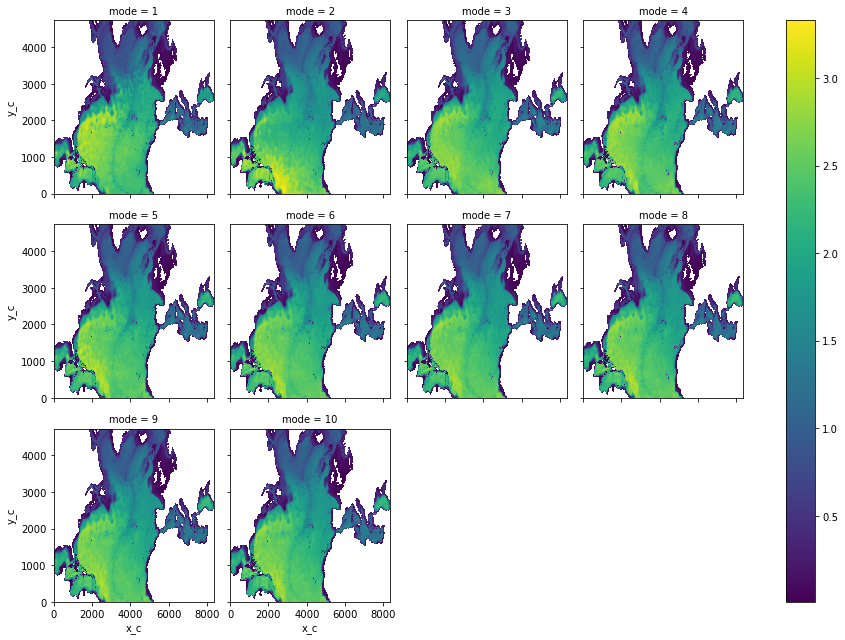

In [11]:
slih = slice(0, None, 4)
toplot = (ds_re.c*ds_re.mode).isel(mode=slice(1,None), x_c=slih, y_c=slih)
toplot.plot(row="mode", col_wrap=4)

### todo 
essayer avec une distribution de chunks en x

In [15]:
sds.x_c[0]

<xarray.DataArray 'x_c' ()>
array(916)
Coordinates:
    x_c      int64 916
Attributes:
    axis:     X

In [9]:
%%time
### custom distribute along x
nchk_x = 2

n_subx = int(sds.x_c.size)//(nchk_x*chunks["x_c"])+1
print("will do {:0d} sub-domain computation along x".format(n_subx))
s_subx = chunks["x_c"]*nchk_x
for ix in range(n_subx):
    tmes = time.time()
    slix = slice(ix*s_subx, (ix+1)*s_subx)
    ssd = sds.isel(x_c=slix)
    region["x_c"] = slice(int(ssd.x_c[0])-1, int(ssd.x_c[-1]))
    vmods = Vmodes(ssd, grid, nmodes=nmodes, free_surf=True, persist=False, chunks={"mode":1})
    vmods.store(out_file, coords=False, mode="a", compute=True, region=region)
    twall, npts = time.time()-tmes, int(ssd.tmaskutil.sum())
    print("slice {0}, {1}, {2:.1f} min for {3} points".format(
                ix, region["x_c"], twall/60, npts),
          "({:.2f} ms/pt)".format(twall/npts*1e3)
         )

will do 12 sub-domain computation along x
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 0, slice(1800, 2200, None), 10.4 min for 99521 points (6.27 ms/pt)
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 1, slice(2200, 2600, None), 20.6 min for 255176 points (4.84 ms/pt)
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 2, slice(2600, 3000, None), 39.0 min for 320000 points (7.31 ms/pt)
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 3, slice(3000, 3400, None), 13.0 min for 156949 points (4.95 ms/pt)
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 4, slice(3400, 3800, None), 30.7 min for 241765 points (7.62 ms/pt)
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 5, slice(3800, 4200, None), 35.4 min for 319484 points (6.64 ms/pt)
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 6, slice(4200, 4600, None)

In [9]:
%%time
### custom distribute along x
nchk_x = 2

n_subx = int(sds.x_c.size)//(nchk_x*chunks["x_c"])+1
print("will do {:0d} sub-domain computation along x".format(n_subx))
s_subx = chunks["x_c"]*nchk_x
for ix in range(n_subx):
    tmes = time.time()
    slix = slice(ix*s_subx, (ix+1)*s_subx)
    ssd = sds.isel(x_c=slix)
    region["x_c"] = slice(int(ssd.x_c[0])-1, int(ssd.x_c[-1]))
    vmods = Vmodes(ssd, grid, nmodes=nmodes, free_surf=True, persist=False, chunks={"mode":1})
    vmods.store(out_file, coords=False, mode="a", compute=True, region=region)
    print("slice {0}, {1}, {2:.1f} min for {3} points".format(
                ix, region["x_c"], (time.time()-tmes)/60, int(ssd.tmaskutil.sum()))
         )

will do 18 sub-domain computation along x
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 0, slice(1000, 1400, None), 2.0 min for 35731 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 1, slice(1400, 1800, None), 14.9 min for 228702 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 2, slice(1800, 2200, None), 19.5 min for 240000 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 3, slice(2200, 2600, None), 20.6 min for 240000 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 4, slice(2600, 3000, None), 19.7 min for 240000 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 5, slice(3000, 3400, None), 18.6 min for 240000 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 6, slice(3400, 3800, None), 18.0 min for 240000 points
Store vertical modes in /scratch/cnt0024/ige2071/n

In [20]:
%%time
### custom distribute along x
nchk_x = 4

n_subx = int(sds.x_c.size)//(nchk_x*chunks["x_c"])+1
print("will do {:0d} sub-domain computation along x".format(n_subx))
s_subx = chunks["x_c"]*nchk_x
for ix in range(n_subx):
    tmes = time.time()
    slix = slice(ix*s_subx, (ix+1)*s_subx)
    ssd = sds.isel(x_c=slix)
    region["x_c"] = slice(int(ssd.x_c[0])-1, int(ssd.x_c[-1]))
    vmods = Vmodes(ssd, grid, nmodes=nmodes, free_surf=True, persist=False, chunks={"mode":1})
    vmods.store(out_file, coords=False, mode="a", compute=True, region=region)
    print("slice {0}, {1}, {2:.1f} min for {3} points".format(
                ix, region["x_c"], (time.time()-tmes)/60, int(ssd.tmaskutil.sum()))
         )

will do 9 sub-domain computation along x
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 0, slice(800, 1600, None), 9.3 min for 106520 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 1, slice(1600, 2400, None), 11.9 min for 159954 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 2, slice(2400, 3200, None), 12.6 min for 160000 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 3, slice(3200, 4000, None), 13.0 min for 160000 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 4, slice(4000, 4800, None), 16.2 min for 160000 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 5, slice(4800, 5600, None), 9.9 min for 109002 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/vmodes.zarr
slice 6, slice(5600, 6400, None), 0.2 min for 0 points
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/v

In [11]:
ds_re = xr.open_zarr(out_file)
sds_re = ds_re.isel(x_c=slice(0,None,4), y_c=slice(0,None,4))

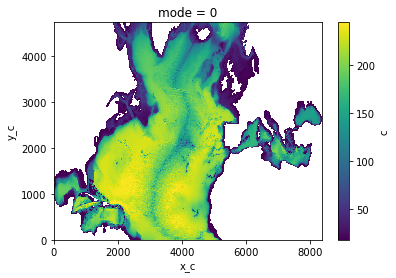

<Figure size 432x288 with 0 Axes>

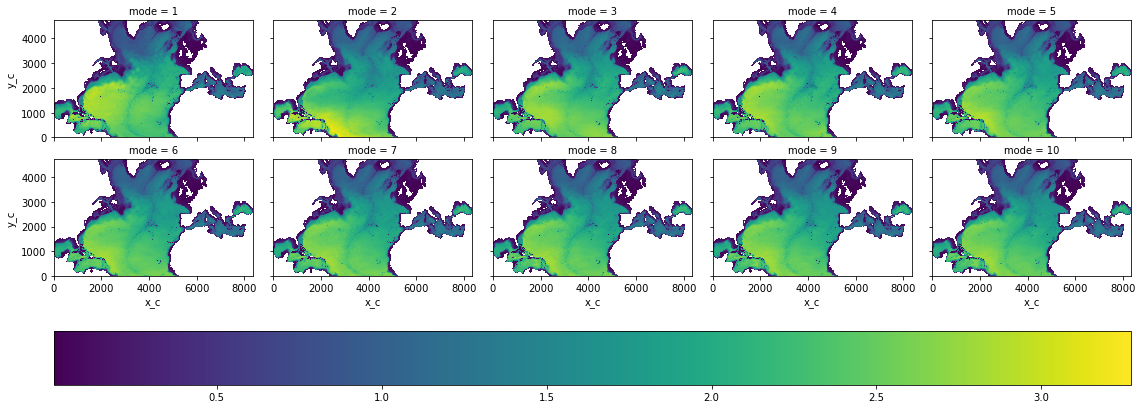

In [10]:
plt.figure()
sds_re.c.isel(mode=0).plot()

plt.figure()
(sds_re.c*sds_re.mode).isel(mode=slice(1,None)).plot(col="mode", col_wrap=5, 
                                       cbar_kwargs={"orientation":"horizontal"})

In [18]:
sds_re

,Array,Chunk
Bytes,103.70 MiB,9.77 kiB
Shape,"(1183, 2089, 11)","(50, 50, 1)"
Count,22177 Tasks,11088 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,103.70 MiB,9.77 kiB
Shape,"(1183, 2089, 11)","(50, 50, 1)"
Count,22177 Tasks,11088 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


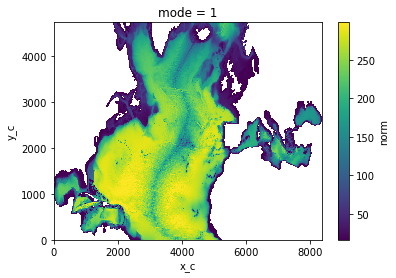

In [19]:
sds_re.norm.isel(mode=1).where(ds.tmaskutil).plot()

## renormalization
because computation was wrong...
WARNING: I should make sure not to copy llon_cc and llat_cc because I don't need them...

In [8]:
#nmodes = 10
work = (Path(os.getenv("WORK1"))/"../SHARED").resolve()
out_new = work/"vmodes/vmodes_{}.zarr".format(nmodes)
out_new

PosixPath('/work/CT1/ige2071/SHARED/vmodes/vmodes_10.zarr')

In [36]:
%%time
ds_re.get(["c"]).to_zarr(out_new, mode="w", consolidated=True)

CPU times: user 19.9 s, sys: 1.05 s, total: 21 s
Wall time: 25.5 s


In [11]:
hocean = dg.e3t.where(dg.tmask).sum("z_c")#.persist()

In [43]:
%%time
(ds_re.get(["norm"]) * hocean / ds_re.norm).to_zarr(out_new, mode="a")

CPU times: user 27.3 s, sys: 1.18 s, total: 28.5 s
Wall time: 30.5 s


In [12]:
renorm = (hocean / ds_re.norm)**.5
renorm = renorm.persist()

In [15]:
%%time

var = "phiw"

region = {"x_c":slice(0,None), "y_c":slice(0,None), "mode":None}
if var == "phiw":
    region["z_l"] = slice(0,None)
else:
    region["z_c"] = slice(0,None)
    
for imod in range(ds_re.mode.size):
    tmes = time.time()
    dsa = ds_re.get([var]).isel(mode=[imod])
    region["mode"] = slice(imod,imod+1)
    (dsa * renorm.isel(mode=[imod])).to_zarr(out_new, mode="a", region=region)
    print("mode {0} done: {1:.1f} s".format(imod,time.time()-tmes))

mode 0 done: 14.5 s
mode 1 done: 14.3 s
mode 2 done: 14.3 s
mode 3 done: 22.5 s
mode 4 done: 14.9 s
mode 5 done: 16.2 s
mode 6 done: 14.4 s
mode 7 done: 14.8 s
mode 8 done: 13.5 s
mode 9 done: 16.2 s
mode 10 done: 15.1 s
CPU times: user 1min 40s, sys: 8.71 s, total: 1min 49s
Wall time: 2min 57s


In [22]:
### add attributes (I lost them somehow during the copying process...)
import zarr

nc = zarr.open(str(out_new), mode="r+")
for k,v in ds_re.attrs.items():
    print(k,v)
    nc.attrs[k] = v

In [30]:
ds_new = xr.open_zarr(out_new)
ds_new

<xarray.Dataset>
Dimensions:    (mode: 11, x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates:
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    c          (y_c, x_c, mode) float32 dask.array<chunksize=(200, 200, 1), meta=np.ndarray>
    norm       (y_c, x_c, mode) float32 dask.array<chunksize=(200, 200, 1), meta=np.ndarray>
    phi        (y_c, x_c, z_c, mode) float32 dask.array<chunksize=(200, 200, 300, 1), meta=np.ndarray>
    phiw       (y_c, x_c, z_l, mode) float32 dask.array<chunksize=(200, 200, 300, 1), meta=np.ndarray>
Attributes:
    N2name:                   bvf
    corr_N:                   True
    eig_sigma:                0.1
    first_order_formulation:  False
    free_surf:                True
    g:                        9.81
    nmodes:                   10
    siz_sparse:               30
    zc_name:                  z_c
    zl_name:                  z_l

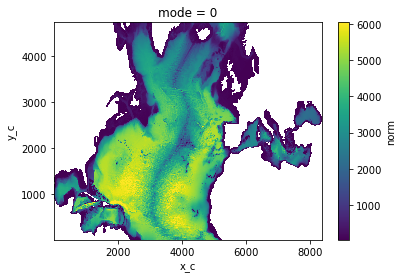

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [17]:
ds_new.norm.isel(mode=0).plot()

In [45]:
## to reload vertical modes: don't use nemodez.load_vmodes
dm = xr.open_zarr(out_new).unify_chunks()
vmods = Vmodes(ds, Grid(ds, periodic=False), nmodes=dm.nmodes, free_surf=dm.free_surf,
              persist=False, chunks={k:v[0] for k,v in dm.chunks.items()})
for v in dm.data_vars:
    vmods.ds[v] = dm[v]
vmods.ds

<xarray.Dataset>
Dimensions:    (mode: 11, x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates: (12/15)
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
    depth_l    (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ...         ...
    hbot       (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    bvf        (z_l, y_c, x_c) float32 dask.array<chunksize=(300, 200, 200), meta=np.ndarray>
    depth_c    (z_c) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    tmask      (z_c, y_c, x_c) int8 dask.array<chunksize=(300, 200, 200), meta=np.ndarray>
    e3t        (z_c, y_c, x_c) float32 dask.array<chunksize=(300, 200, 200), meta=np.ndarray>
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    c          (y_c, x_c, mode) float32 dask.array<chunksize=(200, 200, 1), meta=np.ndarray>
    phi        (y_c, x_c, z_c, mode) float32 dask.array<chunksize=(200, 200, 300, 1), meta=np.ndarray>
    phiw       (y_c, x_c, z_l, mode) float32 dask.array<chunksize=(200, 200, 300, 1), meta=np.ndarray>
    norm       (y_c, x_c, mode) float32 dask.array<chunksize=(200, 200, 1), meta=np.ndarray>

## Old stuff

In [14]:
%%time
### just testing: compute and store with sub-dataset
vmods = Vmodes(sds, grid, nmodes=10, free_surf=True, persist=False, chunks={"mode":1})
vmods.store(scratch/"prov.zarr", coords=False, mode="w", compute=True, 
            consolidated=True)

kwargs in store: {'mode': 'w', 'compute': True, 'consolidated': True}
Store vertical modes in /scratch/cnt0024/ige2071/nlahaye/prov.zarr
CPU times: user 4min 15s, sys: 1min 7s, total: 5min 22s
Wall time: 47min 40s


In [8]:
vmods = Vmodes(ds, Grid(ds, periodic=False), nmodes=10, free_surf=True, 
               persist=False, chunks={"mode":1})
vmods.ds

<xarray.Dataset>
Dimensions:    (mode: 11, x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates: (12/15)
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
    depth_l    (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ...         ...
    hbot       (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    bvf        (z_l, y_c, x_c) float32 dask.array<chunksize=(300, 200, 200), meta=np.ndarray>
    depth_c    (z_c) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    tmask      (z_c, y_c, x_c) int8 dask.array<chunksize=(300, 200, 200), meta=np.ndarray>
    e3t        (z_c, y_c, x_c) float32 dask.array<chunksize=(300, 200, 200), meta=np.ndarray>
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    c          (y_c, x_c, mode) float32 dask.array<chunksize=(200, 200, 1), meta=np.ndarray>
    phi        (y_c, x_c, z_c, mode) float32 dask.array<chunksize=(200, 200, 300, 1), meta=np.ndarray>
    phiw       (y_c, x_c, z_l, mode) float32 dask.array<chunksize=(200, 200, 300, 1), meta=np.ndarray>
    norm       (y_c, x_c, mode) float32 dask.array<chunksize=(200, 200, 1), meta=np.ndarray>

In [10]:
%%time
vmods.ds.isel(x_c=slice(0,10), y_c=slice(0,10)).compute()

CPU times: user 18.2 s, sys: 3.31 s, total: 21.5 s
Wall time: 3min 10s


<xarray.Dataset>
Dimensions:    (mode: 11, x_c: 10, y_c: 10, z_c: 300, z_l: 300)
Coordinates: (12/14)
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
    depth_l    (z_l) float64 -0.0 -1.0 -2.157 ... -5.901e+03 -5.95e+03 -6e+03
    llat_cc    (y_c, x_c) float32 36.79 36.79 36.79 36.79 ... 36.91 36.91 36.91
    llon_cc    (y_c, x_c) float32 -51.28 -51.26 -51.25 ... -51.17 -51.15 -51.13
    tmaskutil  (y_c, x_c) int8 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ...         ...
    e3w        (z_l, y_c, x_c) float64 0.9219 0.9219 0.9219 ... 50.46 50.46
    hbot       (y_c, x_c) float64 5.639e+03 5.636e+03 ... 5.466e+03 5.424e+03
    depth_c    (z_c) float64 -0.4805 -1.559 -2.794 ... -5.975e+03 -6.025e+03
    tmask      (z_c, y_c, x_c) int8 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0
    e3t        (z_c, y_c, x_c) float64 1.0 1.0 1.0 1.0 ... 50.93 50.93 50.93
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    bvf        (z_l, y_c, x_c) float64 0.0001159 0.0001156 0.0001154 ... 0.0 0.0
    c          (y_c, x_c, mode) float64 235.4 2.746 1.099 ... 0.2714 0.2428
    phi        (y_c, x_c, z_c, mode) float64 0.2271 0.6796 0.7979 ... nan nan
    phiw       (y_c, x_c, z_l, mode) float64 1.283e+03 0.5225 0.0983 ... nan nan
    norm       (y_c, x_c, mode) float64 292.0 292.0 292.0 ... 287.0 287.0 287.0

In [12]:
dm = xr.open_zarr(scratch/"vmodes.zarr")
dm

<xarray.Dataset>
Dimensions:  (mode: 11, x_c: 400, y_c: 400, z_c: 300, z_l: 300)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * x_c      (x_c) int64 3001 3002 3003 3004 3005 ... 3396 3397 3398 3399 3400
  * y_c      (y_c) int64 2001 2002 2003 2004 2005 ... 2396 2397 2398 2399 2400
  * z_c      (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l      (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 295.5 296.5 297.5 298.5 299.5
Data variables:
    bvf      (z_l, y_c, x_c) float64 dask.array<chunksize=(300, 400, 200), meta=np.ndarray>
    c        (y_c, x_c, mode) float64 dask.array<chunksize=(400, 200, 1), meta=np.ndarray>
    norm     (y_c, x_c, mode) float64 dask.array<chunksize=(400, 200, 1), meta=np.ndarray>
    phi      (y_c, x_c, z_c, mode) float64 dask.array<chunksize=(400, 200, 300, 1), meta=np.ndarray>
    phiw     (y_c, x_c, z_l, mode) float64 dask.array<chunksize=(400, 200, 300, 1), meta=np.ndarray>
Attributes:
    N2name:      bvf
    corr_N:      True
    eig_sigma:   0.1
    free_surf:   True
    g:           9.81
    nmodes:      10
    siz_sparse:  30
    zc_name:     z_c
    zl_name:     z_l

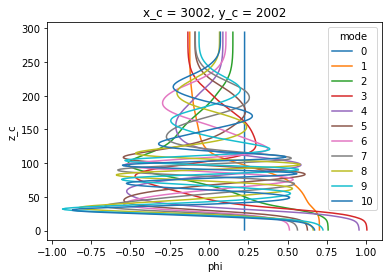

In [17]:
dm.phi.isel(x_c=1, y_c=1).plot.line(y="z_c")

In [10]:
%%time
vmods.ds.reset_coords(drop=True).to_zarr("vmodes.zarr", mode="w")

CPU times: user 1min 30s, sys: 25.1 s, total: 1min 55s
Wall time: 12min 36s


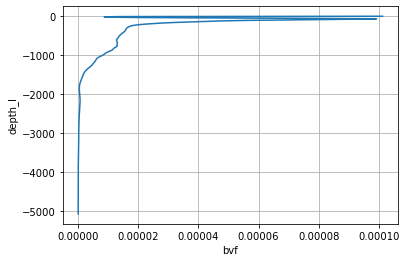

In [15]:
i_rng = slice(4014-1, 4134)
j_rng = slice(1438-1, 1576)

sds = ds_re.isel(x_c=i_rng, y_c=j_rng)
sds.bvf.mean(dim=("x_c", "y_c")).plot(y="depth_l")
plt.grid(True)

In [ ]:
bvf_moy = sds.bvf.mean(dim=("x_c", "y_c")).

## testings


fraction of land points: 0.50
would compute 157 over 220 (fraction not computed: 0.29)


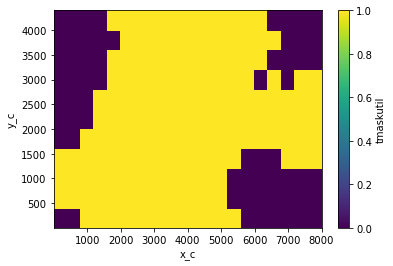

In [20]:
### look at impact of chunking on proportion of non-computed tiles
nchk = 400
print("fraction of land points: {:.2f}".format((ds.tmaskutil==0).mean().values))
comp_tile = ds.tmaskutil.coarsen(x_c=nchk, y_c=nchk, boundary="trim", side="left").max()
print("would compute {} over {} (fraction not computed: {:.2f})".format(comp_tile.sum().values, 
                                                           comp_tile.size,
                                                           1-comp_tile.mean().values)
     )
comp_tile.plot()

In [9]:
from itertools import product
import time

def dist_write_chunks(ds, path, verbose=True, nchk=None):
    """ utilitary function that loops over chunks to store a DataArray in a zarr archive (append mode)"""
    #dim_chk = [next(di for di in da.dims if di.startswith(dim)) for dim in dims]
    if verbose:
        tmei = time.time()
    if isinstance(ds, xr.DataArray):
        name = ds.name if ds.name else "data"
        ds = ds.to_dataset(name=name)
    ### warning this is for testing
    ds = ds.chunk({"z_l":-1})
    
    dims = [*ds.chunks.keys()]
    chks = [np.r_[0, np.array(chk).cumsum()] for chk in ds.chunks.values()]
    if nchk:
        chks = [np.r_[chk[:-1:nchk], chk[-1]] for chk in chks]
        #ds = ds.chunk({di:ds.chunks[di][0]*nchk for di in ["x_c","y_c"] })
    #nks = [len(chk) for chk in ds.chunks.values()]
    nks = [len(chk)-1 for chk in chks] 
    if verbose:
        print("total number of chunks:", np.product(nks), dims, nks)
    ext = [np.arange(nk) for nk in nks]
    for chs in product(*ext):
        if verbose:
            tmes = time.time()
        isel = {dim:slice(*chks[ii][chs[ii]:chs[ii]+2]) for ii,dim in enumerate(dims)}
        ds.isel(isel).to_zarr(path, mode="a", region=isel)
        if verbose:
            print("chunk {}: {:.0f} s".format(chs, time.time()-tmes), end="; ")
            print(isel)
    if verbose:
        print("\n finished. Ellapsed time: {:.1f} min".format((time.time()-tmei)/60))

In [10]:
i_rng = slice(0, 2000) #slice(4014-1, 4134)
j_rng = slice(0, 1000) #slice(1438-1, 1576)

sds = ds.isel(x_c=i_rng, y_c=j_rng)
sds

<xarray.Dataset>
Dimensions:     (x_c: 2000, y_c: 1000, z_c: 300, z_l: 300)
Coordinates:
    e3w         (z_l, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    depth_l_3d  (z_l, y_c, x_c) float32 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    tmask       (z_c, y_c, x_c) int8 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(400, 400), meta=np.ndarray>
    llon_cc     (y_c, x_c) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    llat_cc     (y_c, x_c) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    depth_l     (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
  * x_c         (x_c) int64 1 2 3 4 5 6 7 ... 1994 1995 1996 1997 1998 1999 2000
  * y_c         (y_c) int64 1 2 3 4 5 6 7 8 ... 993 994 995 996 997 998 999 1000
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    votemper    (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    vosaline    (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>

In [20]:
client.restart()

Client Scheduler: tcp://127.0.0.1:41891 Dashboard: http://127.0.0.1:41953/status,Cluster Workers: 8 Cores: 56 Memory: 251.63 GiB


In [16]:
get_bvf(sds, return_ds=True).to_zarr(out_file, mode="w", consolidated=True, compute=False)

Delayed('_finalize_store-f00cb8b3-3c76-40db-9773-c8538d797d7e')

In [16]:
%%time
### no sub-chunking in z for computation (expect truediv done by one thread)
dist_write_chunks(get_bvf(sds, return_ds=True), out_file)

total number of chunks: 15 ['x_c', 'y_c', 'z_l'] [5, 3, 1]
now writing {'x_c': slice(0, 400, None), 'y_c': slice(0, 400, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(400, 800, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(400, 800, None), 'y_c': slice(0, 400, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(400, 800, None), 'y_c': slice(400, 800, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(400, 800, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(800, 1200, None), 'y_c': slice(0, 400, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(800, 1200, None), 'y_c': slice(400, 800, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(800, 1200, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(1200, 1600, 

In [12]:
%%time
dist_write_chunks(get_bvf(sds.chunk({"z_l":50, "z_c":50, "x_c":400, "y_c":400}), return_ds=True), 
                  out_file, nchk=None)

total number of chunks: 15 ['x_c', 'y_c', 'z_l'] [5, 3, 1]
chunk (0, 0, 0): 24 s; chunk (0, 1, 0): 23 s; chunk (0, 2, 0): 22 s; chunk (1, 0, 0): 23 s; chunk (1, 1, 0): 23 s; chunk (1, 2, 0): 21 s; chunk (2, 0, 0): 24 s; chunk (2, 1, 0): 23 s; chunk (2, 2, 0): 21 s; chunk (3, 0, 0): 23 s; chunk (3, 1, 0): 24 s; chunk (3, 2, 0): 21 s; chunk (4, 0, 0): 23 s; chunk (4, 1, 0): 24 s; chunk (4, 2, 0): 22 s; 
 finished. Ellapsed time: 5.7 min
CPU times: user 1min 39s, sys: 13.9 s, total: 1min 53s
Wall time: 5min 42s


In [12]:
%%time
### this is the fastest I found
dist_write_chunks(get_bvf(sds.chunk({"z_l":50, "z_c":50, "x_c":400, "y_c":400}), return_ds=True), 
                  out_file, nchk=2)

total number of chunks: 6 ['x_c', 'y_c', 'z_l'] [3, 2, 1]
chunk (0, 0, 0): 27 s; {'x_c': slice(0, 800, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (0, 1, 0): 23 s; {'x_c': slice(0, 800, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
chunk (1, 0, 0): 28 s; {'x_c': slice(800, 1600, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (1, 1, 0): 23 s; {'x_c': slice(800, 1600, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
chunk (2, 0, 0): 25 s; {'x_c': slice(1600, 2000, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (2, 1, 0): 22 s; {'x_c': slice(1600, 2000, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}

 finished. Ellapsed time: 2.5 min
CPU times: user 45.3 s, sys: 6.15 s, total: 51.4 s
Wall time: 2min 28s


In [21]:
%%time
### this is the fastest I found
dist_write_chunks(get_bvf(sds.chunk({"z_l":20, "z_c":20, "x_c":400, "y_c":400}), return_ds=True), 
                  out_file, nchk=2)

total number of chunks: 6 ['x_c', 'y_c', 'z_l'] [3, 2, 1]
chunk (0, 0, 0): 28 s; {'x_c': slice(0, 800, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (0, 1, 0): 23 s; {'x_c': slice(0, 800, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
chunk (1, 0, 0): 30 s; {'x_c': slice(800, 1600, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (1, 1, 0): 23 s; {'x_c': slice(800, 1600, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
chunk (2, 0, 0): 24 s; {'x_c': slice(1600, 2000, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (2, 1, 0): 22 s; {'x_c': slice(1600, 2000, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}

 finished. Ellapsed time: 2.5 min
CPU times: user 59.6 s, sys: 6.8 s, total: 1min 6s
Wall time: 2min 30s


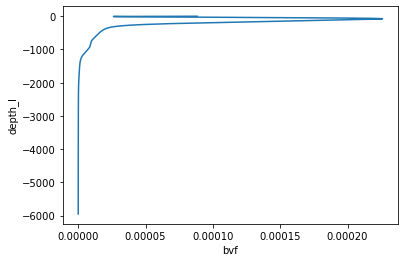

In [14]:
ds_re = xr.open_zarr(out_file)
bvf_moy = ds_re.bvf.mean(dim=("x_c","y_c")).persist()
bvf_moy.plot(y="depth_l")

In [21]:
sds_re = xr.open_zarr(out_file)
ds_re = xr.open_zarr(scratch/"global_mean_bvf.zarr")
#bvf_re = ds_re.bvf.isel(x_c=1999, y_)
bvf_sr = sds_re.bvf.isel(x_c=[-1], y_c=[-1])

In [24]:
sds_re, ds_re = xr.align(sds_re.isel(x_c=[-1], y_c=[-1]), ds_re)
ds_re

<xarray.Dataset>
Dimensions:    (x_c: 1, y_c: 1, z_l: 300)
Coordinates:
  * x_c        (x_c) int64 2000
  * y_c        (y_c) int64 1000
    depth_l    (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    bvf        (z_l, y_c, x_c) float64 dask.array<chunksize=(300, 1, 1), meta=np.ndarray>
Attributes:
    grid_file:  /scratch/cnt0024/ige2071/nlahaye/eNATL60_mean_grid_z.zarr
    mean_salt:  /work/CT1/ige2071/SHARED/mean/global_mean_gridS.zarr
    mean_temp:  /work/CT1/ige2071/SHARED/mean/global_mean_gridT.zarr

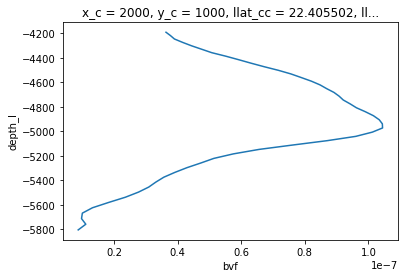

In [27]:
sds_re.bvf.isel(z_l=slice(-52,None)).plot(y="depth_l")

In [13]:
%%time
bvf2(sds).compute()

CPU times: user 23.1 s, sys: 33.1 s, total: 56.2 s
Wall time: 1min 42s


<xarray.DataArray 'bvf' (z_l: 300, y_c: 1000, x_c: 2000)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
          7.87976140e-05,  7.87034078e-05,  7.86151291e-05],
        [            nan,             nan,  3.51709359e-05, ...,
          7.89116195e-05,  7.88216520e-05,  7.87694829e-05],
        [            nan,             nan,             nan, ...,
          7.89817732e-05,  7.89567317e-05,  7.89504024e-05]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
        [            nan,             nan,             nan, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [            nan,             nan, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [            nan,             nan,             nan, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [            nan,             nan, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [            nan,             nan,             nan, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]]])
Coordinates:
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c         (y_c) int64 1 2 3 4 5 6 7 8 ... 993 994 995 996 997 998 999 1000
  * x_c         (x_c) int64 1 2 3 4 5 6 7 ... 1994 1995 1996 1997 1998 1999 2000
    depth_l     (z_l) float64 -0.0 -1.0 -2.157 ... -5.901e+03 -5.95e+03 -6e+03
    e3w         (z_l, y_c, x_c) float64 nan nan nan nan ... 50.46 50.46 50.46
    depth_l_3d  (z_l, y_c, x_c) float32 nan nan nan ... -0.007238 -0.007285
    tmaskutil   (y_c, x_c) int8 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
    llon_cc     (y_c, x_c) float32 -97.88 -97.87 -97.85 ... -64.6 -64.58 -64.57
    llat_cc     (y_c, x_c) float32 6.337 6.337 6.337 6.337 ... 22.41 22.41 22.41

## Old stuff


In [5]:
%%time
#chk_z = 20
ds_tot = load_xorca_dataset(data_files=[], aux_files=grid_files,
                              decode_cf=True, model_config="nest"#, target_ds_chunks={"z_c":chk_z, "z_l":chk_z}
                             ).reset_coords(drop=True)
print("dataset is {:.1f} GB".format(ds_tot.nbytes/1e9))

dataset is 525.4 GB
CPU times: user 9.67 s, sys: 1.03 s, total: 10.7 s
Wall time: 10.7 s


CPU times: user 20.9 s, sys: 6.07 s, total: 27 s
Wall time: 26.5 s


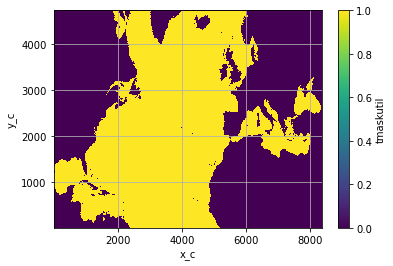

In [6]:
ds_tot

In [13]:
### First load zarr of corected vertical grid
ds_grz = xr.open_zarr(grid_path/zgrid_name)
ds_tot = ds_tot.merge(ds_grz.set_coords("hbot")).drop_vars("sossheig").unify_chunk()

CPU times: user 53min 40s, sys: 4min 56s, total: 58min 37s
Wall time: 58min 25s


In [7]:
i_rng = slice(4014-1, 4134)
j_rng = slice(1438-1, 1576)

sds = ds_tot.isel(x_c=i_rng, x_r=i_rng, y_c=j_rng, y_r=j_rng)
sds

<xarray.Dataset>
Dimensions:     (x_c: 121, x_r: 121, y_c: 139, y_r: 139, z_c: 300, z_l: 300)
Coordinates: (12/39)
  * x_c         (x_c) int64 4014 4015 4016 4017 4018 ... 4131 4132 4133 4134
  * y_c         (y_c) int64 1438 1439 1440 1441 1442 ... 1573 1574 1575 1576
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_r         (y_r) float64 1.438e+03 1.44e+03 ... 1.576e+03 1.576e+03
  * x_r         (x_r) float64 4.014e+03 4.016e+03 ... 4.134e+03 4.134e+03
    ...          ...
    fmask       (z_c, y_r, x_r) int8 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    umaskutil   (y_c, x_r) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    vmaskutil   (y_r, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    fmaskutil   (y_r, x_r) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    hbot        (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
Data variables:
    sossheig    (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    votemper    (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>
    vosaline    (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>

In [14]:
bvf = get_bvf(sds.where(sds.tmask))
bvf

<xarray.DataArray (z_l: 300, y_c: 139, x_c: 121, z_c: 300)>
dask.array<truediv, shape=(300, 139, 121, 300), dtype=float64, chunksize=(299, 139, 121, 300), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c         (y_c) int64 1438 1439 1440 1441 1442 ... 1573 1574 1575 1576
  * x_c         (x_c) int64 4014 4015 4016 4017 4018 ... 4131 4132 4133 4134
    depth_l     (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
    depth_c     (z_c) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    ...          ...
    e2t         (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3t         (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>
    e3w         (z_l, y_c, x_c, z_c) float64 dask.array<chunksize=(300, 139, 121, 300), meta=np.ndarray>
    tmask       (z_c, y_c, x_c) int8 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    hbot        (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>

In [15]:
%%time
bvf.compute()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-4f894727f809dc6298528c32540749c4', 0, 0)": ['tcp://127.0.0.1:44045'], "('getitem-a5d6a77a05891b093bf1ef3c7435f696', 0, 0)": ['tcp://127.0.0.1:44045'], "('truediv-6cf40393a4c78236e732fd4b58be7701', 0, 0, 0, 0)": ['tcp://127.0.0.1:44045'], "('truediv-6cf40393a4c78236e732fd4b58be7701', 1, 0, 0, 0)": ['tcp://127.0.0.1:44045'], "('mul-4df54b8136e8432cbd1a5a5767bd2950', 0, 0, 0, 0)": ['tcp://127.0.0.1:44045']} state: ['waiting', 'waiting', 'waiting', 'waiting', 'waiting'] workers: ['tcp://127.0.0.1:44045']
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://127.0.0.1:44045'], ('getitem-4f894727f809dc6298528c32540749c4', 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promi

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
